In [2]:

import os
import pandas as pd
import numpy as np
import numpy.lib.recfunctions as rfn
from scipy.stats import skew, kurtosis

from io import StringIO
import time

import matplotlib.pyplot as plt
from datetime import datetime, date

from tkinter import filedialog
import tkinter as tk
from tqdm import tqdm
import glob

import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go
import natsort

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.svm import SVR

import seaborn as sns

import http.client
import json

import os
import re
from tqdm import tqdm
from datetime import datetime

#from gps_parameters import GpsConverter1

In [4]:
def calibration(raw_df):
    
    def int_to_datetime(integer):
        try:
            str_dt = str(integer).zfill(6)  # 입력값이 짧으면 앞에 0을 추가
            result_dt = datetime.strptime(str_dt, '%H%M%S')  # 시간 형식으로 변환
            result_unix = result_dt.timestamp()  # 유닉스 타임스탬프로 변환
            return result_unix
        except ValueError as e:
            print(f"ValueError: {integer} is not a valid time format.")
            raise e
    
    def foam2(base, target):
        r1,c1 = base.shape
        r2,c2 = target.shape
        N = c1
        H = c1//2
        pC1 = np.mean(base[:,0:H],1)
        qC1 = np.mean(target[:,0:H],1)
        pC2 = np.mean(base[:,H:c1],1)
        qC2 = np.mean(target[:,H:c1],1)
        pC1 = pC1.reshape(-1,1)
        qC1 = qC1.reshape(-1,1)
        pC2 = pC2.reshape(-1,1)
        qC2 = qC2.reshape(-1,1)
        
        pp = np.zeros((r1,c1))
        pp[:,0:H] = base[:,0:H] - pC1
        pp[:,H:c1] = base[:,H:c1] - pC2
        qp = np.zeros((r2,c2))
        qp[:,0:H] = target[:,0:H] - qC1
        qp[:,H:c1] = target[:,H:c1] - qC2
        B = qp.dot(pp.T)
        detB = np.linalg.det(B)
        froBsq = (np.linalg.norm(B,'fro'))**2
        invB = np.linalg.inv(B)
        adjB = detB *invB
        froadjBsq = np.linalg.norm(adjB,'fro')**2
        lam = 0.5*(np.sum(qp**2)+np.sum(pp**2))
        lamprev = 0.0
        while abs((lam-lamprev)/lam) >= 1e-12:
            lamprev = lam
            tmp = lam**2 - froBsq
            lam = lam - (tmp**2 - 8*lam*detB - 4*froadjBsq)/(4*tmp*lam - 8*detB)
        R = ((lam**2 + froBsq)*B + 2*lam*adjB.T - 2*np.matmul(B,np.matmul(B.T,B))) / (lam*(lam**2 - froBsq) - 2*detB)
        t1 = qC1 - np.matmul(R, pC1)
        t2 = qC2 - np.matmul(R, pC2)
        pp = np.zeros((r1,c1))
        pp[:,:H] += np.matmul(R,base)[:,:H] + t1
        pp[:,H:] += np.matmul(R,base)[:,H:] + t2
        err = np.mean(np.sqrt(np.sum((target-pp)**2,1)))
        return R,t1,t2,err

    def foam(base, target):
        r1,c1 = base.shape
        r2,c2 = target.shape
        
        pC = np.mean(base[:,:],1)
        qC = np.mean(target[:,:],1)
        pC = pC.reshape(-1,1)
        qC = qC.reshape(-1,1)
        
        pp = np.zeros((r1,c1))
        pp[:,:] = base[:,:] - pC
        qp = np.zeros((r2,c2))
        qp[:,:] = target[:,:] - qC
        B = qp.dot(pp.T)
        detB = np.linalg.det(B)
        froBsq = (np.linalg.norm(B,'fro'))**2
        try:
            invB = np.linalg.inv(B)
        except Exception as e:
            raise e 
            return False, False, False
        invB = np.linalg.inv(B)
        adjB = detB *invB
        froadjBsq = np.linalg.norm(adjB,'fro')**2
        lam = 0.5*(np.sum(qp**2)+np.sum(pp**2))
        lamprev = 0.0
        while abs((lam-lamprev)/lam) >= 1e-12:
            lamprev = lam
            tmp = lam**2 - froBsq
            lam = lam - (tmp**2 - 8*lam*detB - 4*froadjBsq)/(4*tmp*lam - 8*detB)
        R = ((lam**2 + froBsq)*B + 2*lam*adjB.T - 2*np.matmul(B,np.matmul(B.T,B))) / (lam*(lam**2 - froBsq) - 2*detB)
        t1 = qC - np.matmul(R, pC)
        pp = np.zeros((r1,c1))
        pp[:,:] += np.matmul(R,base)[:,:] + t1
        err = np.mean(np.sqrt(np.sum((target-pp)**2,1)))
        return R,t1,err

    def movmean(lst, window):
        return np.convolve(lst, np.ones(window)/window, mode='same')

    def get_pseudo_acc(timestamp, gps_speed, gps_heading):
        #timestamp_seconds = timestamp.astype('int64') / 1e9
        if gps_heading[0] == None:
            gps_heading[0] = gps_heading.copy()[1]
        gps_speed_ms = gps_speed/3.6
        #gps_heading_tmp = np.deg2rad(gps_heading)
        gps_heading_rad = np.unwrap(gps_heading)
        pgyrZ = np.convolve(np.gradient(-gps_heading_rad)/np.gradient(timestamp), np.ones(10)/10, mode='same')
        paccX = np.gradient(gps_speed_ms)/np.gradient(timestamp)
        paccY = pgyrZ * gps_speed_ms
        return paccX, paccY, pgyrZ
    
    
    def static_imu_align(data, use_gyro = False, speed_thres = 5):
        #display(data)
        data = data.copy()
        # mask = np.where((data['numSV']<satellite_thres) | (data['Speed']<=speed_thres))
        mask = np.where((data['Speed']/3.6<=speed_thres))

        pseudo_acc_x, pseudo_acc_y, pseudo_gyr_z = get_pseudo_acc(data["TimeStamp"], data['Speed'], data['Heading'])
        pseudo_acc_z = np.ones(len(pseudo_gyr_z))*9.816
        pseudo_gyr_x = np.zeros(len(pseudo_gyr_z))
        pseudo_gyr_y = np.zeros(len(pseudo_gyr_z))

        pseudo_acc_x[mask] = 0
        pseudo_acc_y[mask] = 0
        pseudo_acc_z[mask] = 0
        pseudo_gyr_z[mask] = 0

        raw_acc_x = movmean(data['AccelX'],20)
        raw_acc_y = movmean(data['AccelY'],20)
        raw_acc_z = movmean(data['AccelZ'],20)
        raw_gyr_x = movmean(data['AngleRateX'],20)
        raw_gyr_y = movmean(data['AngleRateY'],20)
        raw_gyr_z = movmean(data['AngleRateZ'],20)

        raw_acc_x[mask] = 0
        raw_acc_y[mask] = 0
        raw_acc_z[mask] = 0
        raw_gyr_x[mask] = 0
        raw_gyr_y[mask] = 0
        raw_gyr_z[mask] = 0

        if use_gyro:

            # R*base + bias = target
            base = np.hstack((np.vstack((raw_acc_x, raw_acc_y, raw_acc_z)), np.rad2deg(np.vstack((raw_gyr_x, raw_gyr_y, raw_gyr_z)))))
            target = np.hstack((np.vstack((pseudo_acc_x, pseudo_acc_y, pseudo_acc_z)), np.rad2deg(np.vstack((pseudo_gyr_x, pseudo_gyr_y, pseudo_gyr_z)))))

            rotmat, bias_acc, bias_gyr, err = foam2(base, target)

        else:
            base = np.vstack((raw_acc_x, raw_acc_y, raw_acc_z))
            target = np.vstack((pseudo_acc_x, pseudo_acc_y, pseudo_acc_z))

            rotmat, bias_acc, err = foam(base, target)
            bias_gyr = np.mean(np.deg2rad(np.vstack((raw_gyr_x[mask], raw_gyr_y[mask], raw_gyr_z[mask]))), axis = 1)
            
        return (rotmat, bias_acc, np.deg2rad(bias_gyr), err)

    df = raw_df.copy()
    df = df.loc[(df["numSV"] > 5) & (df["Speed"] > 3)].copy()
    # Remove duplicate time for cali
    # df.drop_duplicates(subset=['datetime'], inplace=True)
    #df['unixtime'] = list(map(lambda x: int_to_datetime(x), df.index))

    # KEY MATCHING for Smartlink
    df["TimeStamp"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df["UnixTime"] = df["TimeStamp"].apply(lambda x: x.timestamp())
    data = np.array([tuple(x) for x in np.vstack( \
                # (df_N088_filtered['iTOW']/1000.0, \
                (df['UnixTime'], \
                    df['numSV'], \
                    df['Speed'], \
                    df['AccelX'], \
                    df['AccelY'], \
                    df['AccelZ'], \
                    df['AngleRateX'], \
                    df['AngleRateY'], \
                    df['AngleRateZ'], \
                    df["headMot"]
                    )).T], \
                    # df_sk_filtered['lat'], \
                    # df_sk_filtered['lon'])).T], \
                dtype = [('TimeStamp', None), \
                        ('numSV', None), \
                        ('Speed', None), \
                        ('AccelX', None), \
                        ('AccelY', None), \
                        ('AccelZ', None), \
                        ('AngleRateX', None), \
                        ('AngleRateY', None), \
                        ('AngleRateZ', None), \
                        ('Heading', None),
                        ])
                        # ('Latitude', None), \
                        # ('Longitude', None)])

    # RUN CALIBRATION
    try:
        rotmat, bias_acc, bias_gyr, err = static_imu_align(data, use_gyro=True)
        #display(rotmat)
        cal_acc = np.matmul(rotmat, np.vstack((raw_df['AccelX'], raw_df['AccelY'], raw_df['AccelZ']))) + bias_acc.reshape(3,1)
        cal_gyr = np.matmul(rotmat, np.vstack((raw_df['AngleRateX'], raw_df['AngleRateY'], raw_df['AngleRateZ']))) + bias_gyr.reshape(3,1)
    except Exception as e:
        print(e)
        raise e
    
    import time
    try:
        cal_name = "cal"
        raw_df['AccelX'] = cal_acc[0]
        raw_df['AccelY'] = cal_acc[1]
        raw_df['AccelZ'] = cal_acc[2]
        raw_df[f'AngleRateX_{cal_name}'] = cal_gyr[0]
        raw_df[f'AngleRateY_{cal_name}'] = cal_gyr[1]
        raw_df[f'AngleRateZ_{cal_name}'] = cal_gyr[2]
    except Exception as e:
        print(e)
        raw_df = rfn.append_fields(raw_df,'AccelX', cal_acc[0])
        raw_df = rfn.append_fields(raw_df,'AccelY', cal_acc[1])
        raw_df = rfn.append_fields(raw_df,'AccelZ', cal_acc[2])
        raw_df = rfn.append_fields(raw_df,'GyroX', cal_gyr[0])
        raw_df = rfn.append_fields(raw_df,'GyroY', cal_gyr[1])
        raw_df = rfn.append_fields(raw_df,'GyroZ', cal_gyr[2])
        raise e
    return raw_df

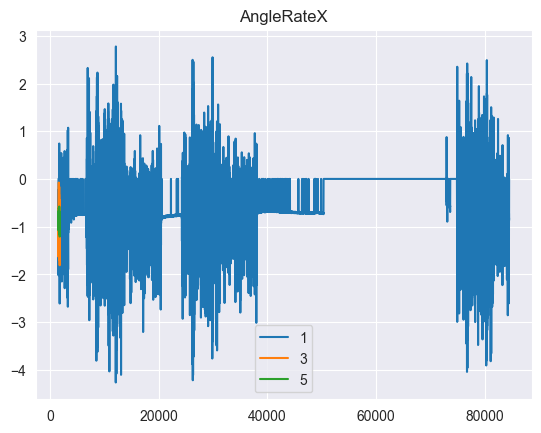

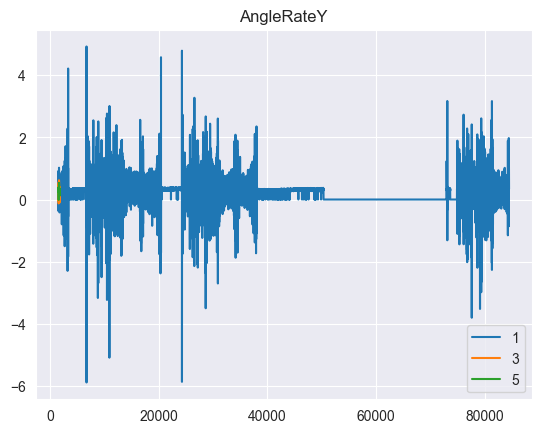

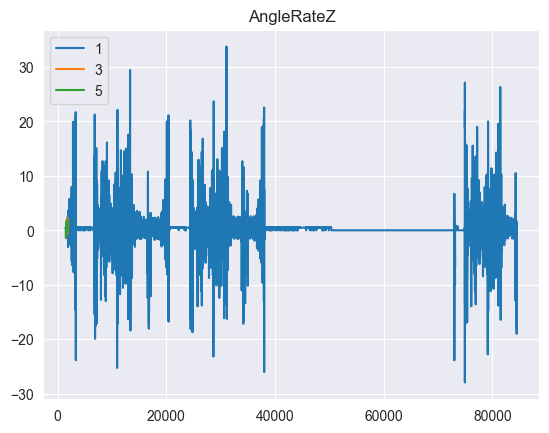

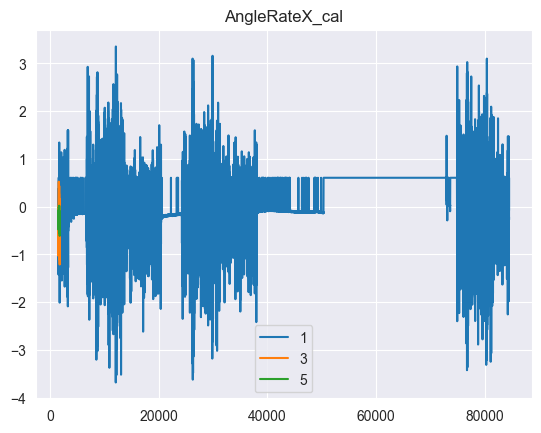

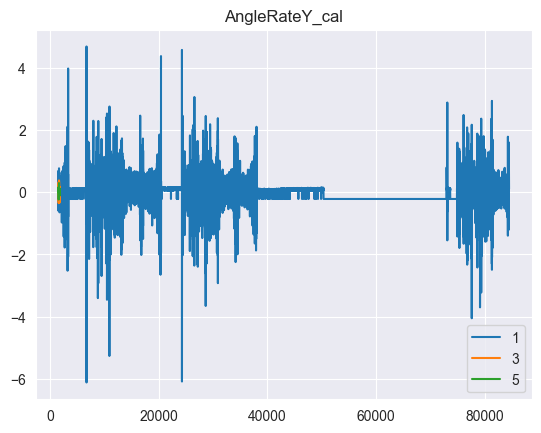

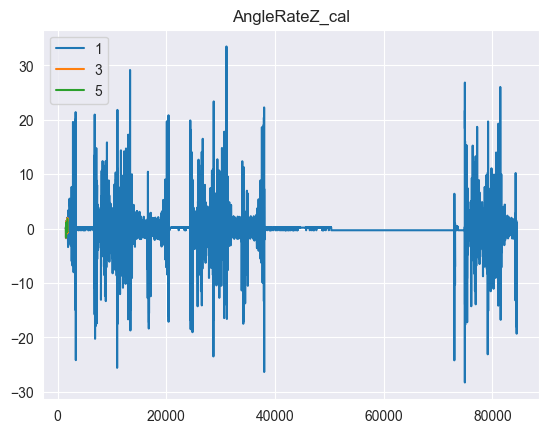

In [5]:
acc_file = pd.read_csv(fr"C:\Users\양준원\PycharmProjects\DPS_GPS_Outage\20240909.csv")
kk = calibration(acc_file)
for col in acc_file.columns:
    if "175" in col:
        acc_file[col[:-4]] = acc_file[col].copy()
        acc_file = acc_file.drop(columns=[col])
    if "Unnamed" in col:
        acc_file = acc_file.drop(columns=[col])
        
for pos in ["LF", "RF", "RR", "RL"][:1]:
    LF_tire = kk[[col for col in kk.columns if "AngleRateY" in col or "AngleRateZ" in col or "AngleRateX" in col]] #f"{pos}_TIRE_AccelZ"

    for col in LF_tire:
        plt.title(col)
        plt.plot(LF_tire.loc[1500:, col].rolling(1).mean(), label="1")
        plt.plot(LF_tire.loc[1500:1800, col].rolling(3, center=True).mean(), label="3")
        plt.plot(LF_tire.loc[1500:1800, col].rolling(10, center=True).mean(), label="5")
        plt.legend()
        plt.show()


C:\Users\HANTA\AppData\Local\Temp\ipykernel_29824\1690797693.py:91: RuntimeWarning:

invalid value encountered in arcsin



<Figure size 640x480 with 0 Axes>

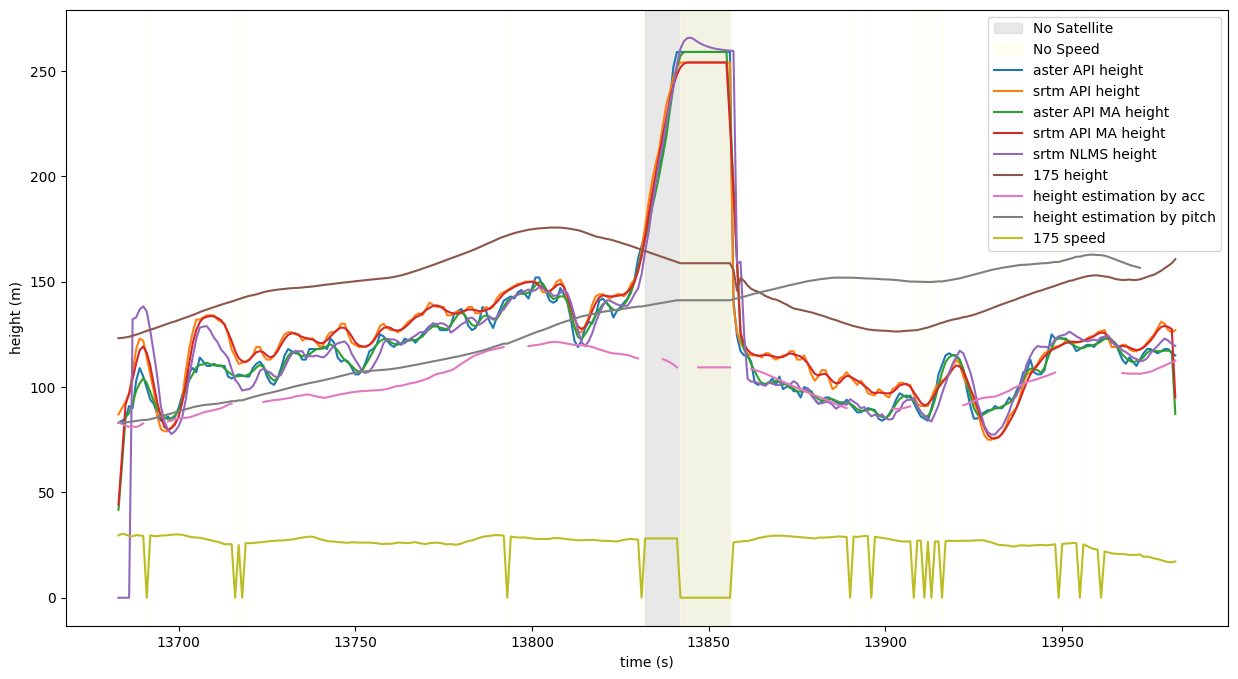

,height_GPS_175,height_GPS_175,height_175,Height_Slope1_175
height_GPS_175,1.000000,1.000000,0.565375,0.502224
height_GPS_175,1.000000,1.000000,0.565375,0.502224
height_175,0.565375,0.565375,1.000000,0.929013
Height_Slope1_175,0.502224,0.502224,0.929013,1.000000


,AngleRateY_cal,Slope4_175
13683,0.037384,NaN
13684,0.238634,0.001333
13685,-0.191380,0.005026
13686,-0.074573,0.007455
13687,-0.040233,0.008410
...,...,...
13978,-0.275344,NaN
13979,-0.326336,NaN
13980,-0.068530,NaN
13981,0.084959,NaN


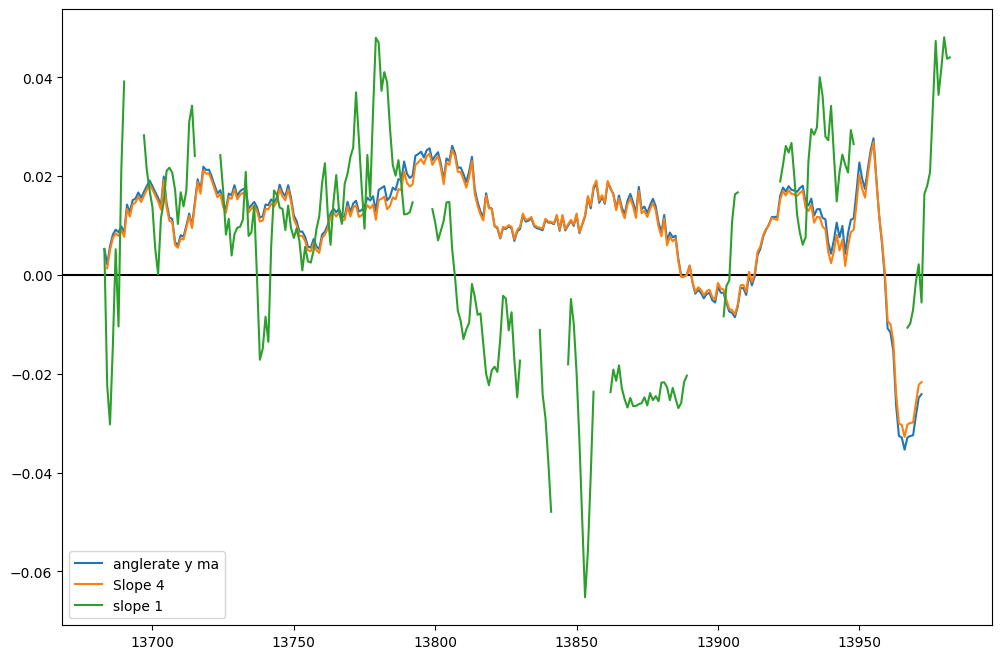

zero speed condition occured
zero speed condition occured


C:\Users\HANTA\AppData\Local\Temp\ipykernel_29824\1690797693.py:91: RuntimeWarning:

invalid value encountered in arcsin



<Figure size 640x480 with 0 Axes>

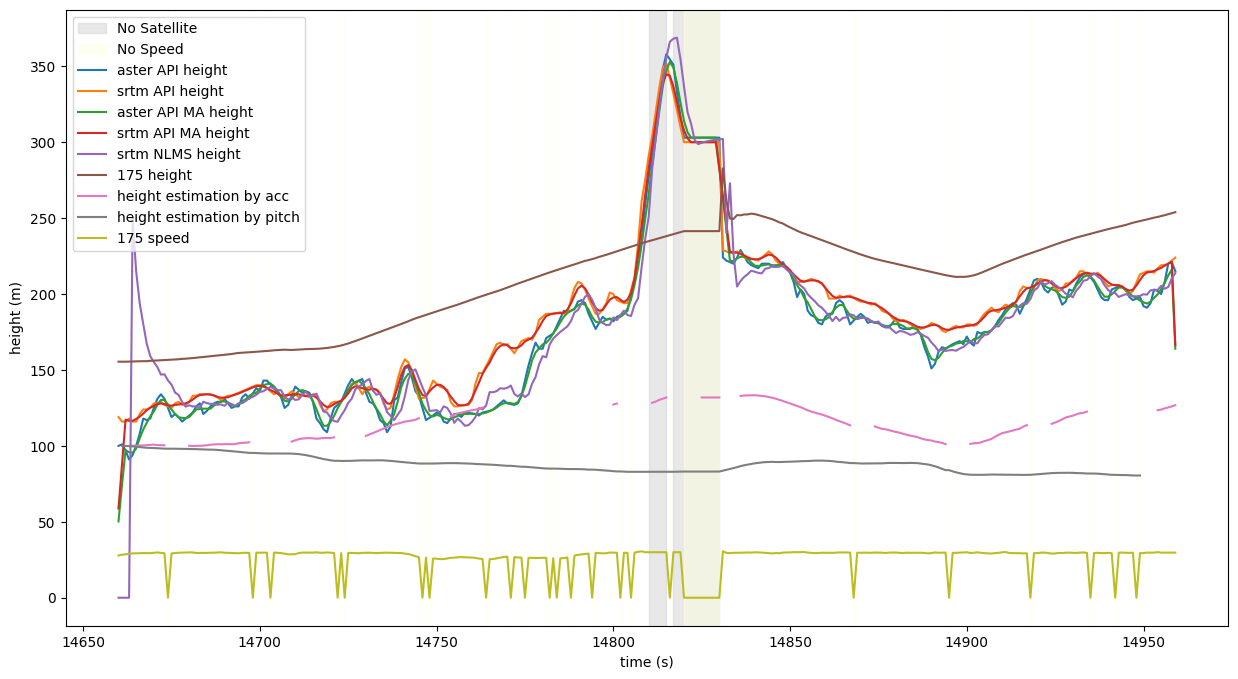

,height_GPS_175,height_GPS_175,height_175,Height_Slope1_175
height_GPS_175,1.000000,1.000000,0.787199,0.693512
height_GPS_175,1.000000,1.000000,0.787199,0.693512
height_175,0.787199,0.787199,1.000000,0.761711
Height_Slope1_175,0.693512,0.693512,0.761711,1.000000


,AngleRateY_cal,Slope4_175
14660,0.022312,NaN
14661,0.127091,0.000117
14662,0.313824,-0.001618
14663,0.057771,-0.003239
14664,0.078825,-0.006228
...,...,...
14955,0.103849,NaN
14956,0.029996,NaN
14957,0.100196,NaN
14958,0.625983,NaN


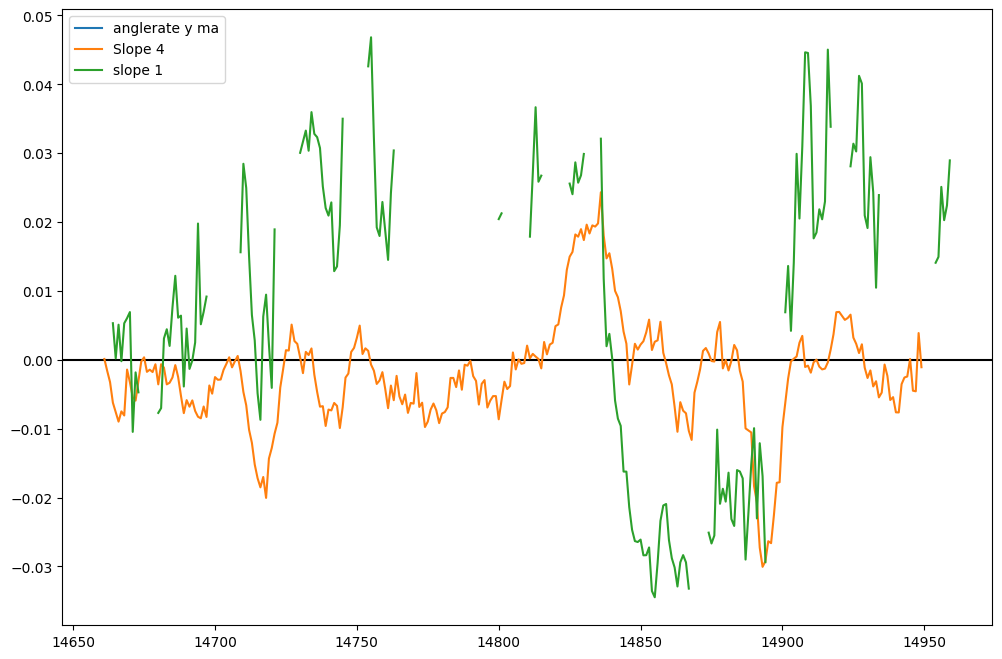

,datetime,unixtime,Speed_175,AccelX_175,AccelY_175,AccelZ_175,AngleRateX_175,AngleRateY_175,AngleRateZ_175,hAcc_175,...,aster30m_175,srtm30m_175,aster30m_MA_175,srtm30m_MA_175,NLMS_175,RLS_175,Slope1_175,Height_Slope1_175,Slope4_175,Height_Slope4_175
13683,2024-09-09 03:48:04,1725853684,29.606,0.633777,0.037915,10.026120,-0.597197,0.265581,0.432250,1.8,...,83.0,87.0,41.75,44.25,0.000000,0.000000,0.005255,0.155573,NaN,NaN
13684,2024-09-09 03:48:05,1725853685,30.288,-0.454321,0.263340,9.995568,-1.011909,0.472919,0.686209,1.8,...,84.0,90.0,63.00,67.50,0.000000,0.000000,-0.022411,-0.523314,0.001333,0.040386
13685,2024-09-09 03:48:06,1725853686,30.019,-0.613406,-0.029828,9.951560,-0.925934,0.045410,0.208920,1.8,...,85.0,93.0,85.75,91.75,0.000000,0.000000,-0.030251,-1.431707,0.005026,0.191266
13686,2024-09-09 03:48:07,1725853687,29.324,0.218889,-0.155098,10.094282,-0.903607,0.162969,0.079838,1.8,...,91.0,97.0,87.50,96.75,0.000000,0.000000,-0.014355,-1.852696,0.007455,0.409882
13687,2024-09-09 03:48:08,1725853688,29.176,0.777697,0.057627,9.998069,-0.648915,0.188563,0.478748,1.8,...,90.0,107.0,92.25,103.75,132.139044,-24.739871,0.005190,-1.701279,0.008410,0.655271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14955,2024-09-09 04:09:16,1725854956,29.669,0.270823,0.079357,9.803220,-0.846597,0.337334,0.404521,1.9,...,200.0,219.0,203.25,217.25,205.346449,205.943362,0.014942,23.946709,NaN,NaN
14956,2024-09-09 04:09:17,1725854957,29.670,0.237702,0.084000,10.009384,-0.959664,0.265652,0.414152,1.9,...,208.0,219.0,207.50,218.75,203.502389,206.921617,0.025110,24.691865,NaN,NaN
14957,2024-09-09 04:09:18,1725854958,29.702,0.270648,0.116037,9.961795,-1.134024,0.339143,0.440215,1.9,...,220.0,220.0,212.25,220.00,204.622980,203.168614,0.020276,25.294183,NaN,NaN
14958,2024-09-09 04:09:19,1725854959,29.711,0.321572,0.065785,9.564945,-1.327147,0.867577,0.590571,1.9,...,221.0,222.0,216.00,221.25,210.293897,212.368216,0.022430,25.960723,NaN,NaN


In [36]:
import padasip as pa

acc_file_aster = pd.read_csv(fr"Y:\99_Code_Library\YJW\6.data\06.Sensor_compare\slope_compare\gps\20240909_aster.csv")
acc_file_org = pd.read_csv(fr"Y:\99_Code_Library\YJW\6.data\06.Sensor_compare\slope_compare\raw\2024_09_09.csv")
acc_file = pd.read_csv(fr"Y:\99_Code_Library\YJW\6.data\102.GPS_outage\175\20240909.csv")
acc_file = calibration(acc_file)

acc_file_aster['datetime'] = pd.to_datetime(acc_file_aster['datetime'])
acc_file_aster["unixtime"] = acc_file_aster['datetime'].astype('int64') // 10**9

window_size = 4

f_NLMS = pa.filters.AdaptiveFilter(model="NLMS", n=window_size, mu=0.2, w="random")
f_RLS = pa.filters.FilterRLS(n=window_size, mu=0.3, w="random")
    
def create_sliding_window(data, window_size):
    x = np.zeros((len(data), window_size))
    for i in range(window_size, len(data)):
        x[i] = data[i-window_size:i][::-1]
    return x #np.array([data[i-window_size:i][::-1] for i in range(window_size, len(data))])

def group_consecutive(data):
    return np.split(data, np.where(np.diff(data) != 1)[0] + 1)


# n1, n2 

id_ = 137

point = 2000
n1 = 7000
n2 = 15000 #len(acc_file_aster)

# 밑의 데이터 센서 별로 통합하기 ==> 저장하기


total_outage_df_list = []
search_index = [i for i in range(n1, n2)]

for idx in range(n1, n2):
    if acc_file_aster.loc[idx, f"numSV_{id_}"] < 1:        
        if idx in search_index:
            
            idx_list = sorted(list(set([min(len(acc_file_aster)-1, max(idx + i, 0)) for i in range(-150, 150)])))
            search_index = list(filter(lambda x: x not in idx_list, search_index))
            
            sensor_df_list = []
            sensor_df_list.append(acc_file_aster.loc[idx_list][["datetime", "unixtime"]])
            
            for sensor_idx in [175, 170, 137][:1]:
                id_ = sensor_idx
                
                zero_SV_index = acc_file_aster.loc[(acc_file_aster.index.isin(idx_list)) & (acc_file_aster[f"numSV_{id_}"] < 1)].index
                zero_vel_index = acc_file_aster.loc[(acc_file_aster.index.isin(idx_list)) & (acc_file_aster[f"Speed_{id_}"] < 1)].index
                
                if len(zero_vel_index) > 0.4 * len(idx_list):
                    print("zero speed condition occured")
                    continue
                
                sensor_df = acc_file_aster.loc[idx_list][[col for col in acc_file_aster.columns if str(id_) in col]].copy()
                sensor_df.loc[idx_list, "status"] = 0
                sensor_df.loc[zero_SV_index, "status"] = 1
                sensor_df.loc[zero_vel_index, "status"] = 2
                
                sensor_df.loc[idx_list, f"aster30m_{id_}"] = acc_file_aster.loc[idx_list, f"height_GPS_{id_}"].interpolate(method='linear', limit_direction='forward', axis=0)
                sensor_df.loc[idx_list, f"srtm30m_{id_}"] =acc_file_org.loc[idx_list, f"height_GPS_{id_}"].interpolate(method='linear', limit_direction='forward', axis=0)
                
                aster_list = sensor_df.loc[idx_list, f"aster30m_{id_}"].copy()
                srtm_list = sensor_df.loc[idx_list, f"srtm30m_{id_}"].copy()
                
                sensor_df.loc[idx_list, f"aster30m_MA_{id_}"] = pd.Series(np.convolve(aster_list, [1/window_size for _ in range(window_size)], mode='same'), index = idx_list)
                sensor_df.loc[idx_list, f"srtm30m_MA_{id_}"] = pd.Series(np.convolve(srtm_list, [1/window_size for _ in range(window_size)], mode='same'), index = idx_list)
                
                aster_list_MA = sensor_df.loc[idx_list, f"aster30m_MA_{id_}"].copy()
                srtm_list_MA = sensor_df.loc[idx_list, f"srtm30m_MA_{id_}"].copy()
                
                y_NLMS, e, w = f_NLMS.run(aster_list.reset_index(drop=True), create_sliding_window(srtm_list.reset_index(drop=True), window_size = window_size))
                y_RLS, e, w = f_RLS.run(aster_list.reset_index(drop=True), create_sliding_window(srtm_list.reset_index(drop=True), window_size = window_size))
                
                sensor_df.loc[idx_list, f"NLMS_{id_}"] = pd.Series(y_NLMS, index=idx_list)
                sensor_df.loc[idx_list, f"RLS_{id_}"] = pd.Series(y_RLS, index=idx_list)
                
                y_NLMS_series = sensor_df.loc[idx_list, f"NLMS_{id_}"].copy()
                y_RLS_series = sensor_df.loc[idx_list, f"RLS_{id_}"].copy()
                
                Accx_MA = np.convolve(acc_file[f"AccelX"], np.ones(1)/1, mode="same")
                Accx_psuedo = acc_file[f"Speed"].diff()
                
                # ACCX MA, ACCX psuedo are not included in sensor_df
                
                sensor_df.loc[idx_list, f"Slope1_{id_}"] = acc_file.apply(lambda x : np.clip(np.arcsin((Accx_MA[x.name] - Accx_psuedo.iloc[x.name])/9.816), -np.pi/2, np.pi/2), axis = 1).rolling(5).mean()
                sensor_df.loc[idx_list, f"Height_Slope1_{id_}"] = sensor_df.loc[idx_list].apply(lambda x : x[f"Speed_{id_}"]*np.tan(x[f"Slope1_{id_}"]), axis = 1)
                sensor_df.loc[idx_list, f"Height_Slope1_{id_}"] = sensor_df.loc[idx_list, f"Height_Slope1_{id_}"].cumsum()
                
                GPS_height = sensor_df.loc[idx_list, f"height_{id_}"].interpolate(method='linear', limit_direction='forward', axis=0)
                pitch_list = pd.Series(np.roll(acc_file.loc[idx_list, f"AngleRateY_cal"].rolling(10).mean(), -10), index = idx_list).diff()/10
                sensor_df.loc[idx_list, f"Slope4_{id_}"] = sensor_df.apply(lambda x : np.clip(pitch_list[x.name], -1, 1), axis = 1)
                sensor_df.loc[idx_list, f"Slope4_{id_}"] = (GPS_height.iloc[1] - GPS_height.iloc[0])/sensor_df["Speed_175"].iloc[0] + sensor_df.loc[idx_list, f"Slope4_{id_}"].cumsum()
                sensor_df.loc[idx_list, f"Height_Slope4_{id_}"] = sensor_df.loc[idx_list].apply(lambda x : x[f"Speed_{id_}"]*np.tan(x[f"Slope4_{id_}"]), axis = 1)
                sensor_df.loc[idx_list, f"Height_Slope4_{id_}"] = sensor_df.loc[idx_list, f"Height_Slope4_{id_}"].cumsum()
                
                plt.clf()
                plt.figure(figsize=(15,8))
                sv_groups = group_consecutive(zero_SV_index)
                for group in sv_groups:
                    if len(group) > 0:
                        plt.axvspan(min(group), max(group), color='lightgray', alpha=0.5, label='No Satellite')

                # 속도 데이터에 대한 처리
                vel_groups = group_consecutive(zero_vel_index)
                for group in vel_groups:
                    if len(group) > 0:
                        plt.axvspan(min(group), max(group), color='lightyellow', alpha=0.5, label='No Speed')
                
                # plt.axvspan(min(zero_SV_index), max(zero_SV_index), color='lightgray', alpha=0.5, label='No Satellite')
                # plt.axvspan(min(zero_vel_index), max(zero_vel_index), color='lightyellow', alpha=0.5, label='No Speed')
                
                plt.plot(aster_list, label = "aster API height")
                plt.plot(srtm_list, label = "srtm API height")
                plt.plot(aster_list_MA, label = "aster API MA height")
                plt.plot(srtm_list_MA, label = "srtm API MA height")
                plt.plot(y_NLMS_series, label = "srtm NLMS height")
                #plt.plot(y_RLS_series, label = "srtm RLS height")
                plt.plot(GPS_height, label = f"{id_} height")
                plt.plot(sensor_df.loc[idx_list, f"Height_Slope1_{id_}"] + list(aster_list)[0], label="height estimation by acc")
                plt.plot(sensor_df.loc[idx_list, f"Height_Slope4_{id_}"] + list(aster_list)[0], label="height estimation by pitch")
                plt.plot(sensor_df.loc[idx_list, f"Speed_{id_}"].interpolate(method='linear', limit_direction='forward', axis=0), label = f"{id_} speed")
                plt.xlabel("time (s)")
                plt.ylabel("height (m)")
                
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                plt.legend(by_label.values(), by_label.keys())
                plt.show()
                
                
                
                
                fig = px.scatter_mapbox(sensor_df.loc[idx_list], lat = f'lat_{id_}', lon= f'lon_{id_}', color= f"status", zoom=15, mapbox_style='open-street-map', color_continuous_scale='turbo').update_traces(marker={'size':5})
                fig.update_layout(
                    width = 1200,
                    height = 900,
                    margin = dict(l=0, r=0, t=0, b=0),
                )
                fig.show()

                display(pd.concat([sensor_df.loc[idx_list, f"height_GPS_{id_}"], sensor_df.loc[idx_list, f"height_GPS_{id_}"], sensor_df.loc[idx_list,f"height_{id_}"], sensor_df.loc[idx_list,f"Height_Slope1_{id_}"]], axis = 1).corr())
                display(pd.concat([acc_file.loc[idx_list, "AngleRateY_cal"], sensor_df.loc[idx_list, f"Slope4_{id_}"]], axis = 1))
                sensor_df_list.append(sensor_df)
                
                f_NLMS = pa.filters.AdaptiveFilter(model="NLMS", n=window_size, mu=0.2, w="random")


                window_size_ = 4
                delta = 4

                dataf = sensor_df.copy()
                #y_NLMS, e, w = f_NLMS.run(total_outage_df["AngleRateY_175"].reset_index(drop=True), create_sliding_window(np.roll(sensor_df["AngleRateY_175"].reset_index(drop=True), -delta), window_size = window_size_))
                ary_ma = pd.Series(np.roll(dataf["AngleRateY_175"].rolling(10).mean(), -10), index = dataf.index)

                plt.figure(figsize=(12,8))
                plt.axhline(0, color="black")
                #plt.plot(sensor_df["AngleRateY_175"].rolling(1).mean(), label="anglerate y")
                #plt.plot(pd.Series(y_NLMS, index = sensor_df.index), label="anglerate y ale")
                plt.plot(((ary_ma - ary_ma.iloc[0])/10+ dataf["Slope1_175"].iloc[0]), label="anglerate y ma")
                #plt.plot(list(sensor_df["Slope1_175"])[0] + ary_ma.diff().cumsum(), label="psuedo slope")
                plt.plot(dataf["Slope4_175"], label="Slope 4")
                plt.plot(dataf["Slope1_175"], label="slope 1")
                plt.legend()
                plt.show()
            

            sensor_df_join = pd.concat(sensor_df_list, axis=1)
            total_outage_df_list.append(sensor_df_join)

total_outage_df = total_outage_df_list[0]

for df in total_outage_df_list[1:]:
    new_rows = df[~df.index.isin(total_outage_df.index)]
    total_outage_df = pd.concat([total_outage_df, new_rows], axis=0)

total_outage_df


214 229
zero speed, detect as default distance
403 422
zero speed, detect as default distance
1667 1685
zero speed, detect as default distance
2237 2261
zero speed, detect as default distance


c:\Users\HANTA\anaconda3\envs\guym\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



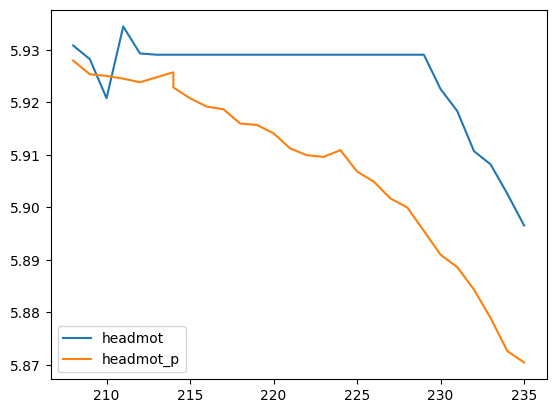

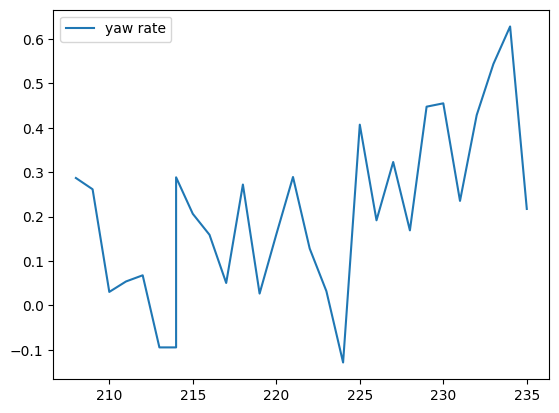

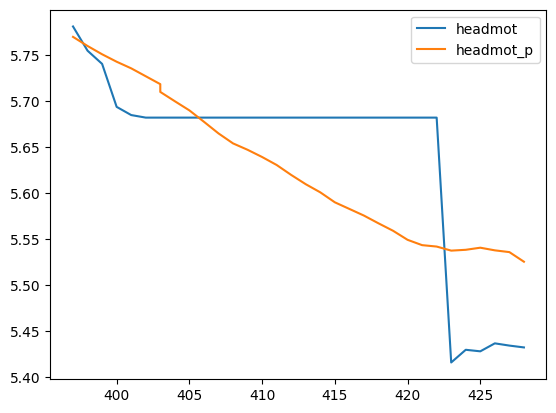

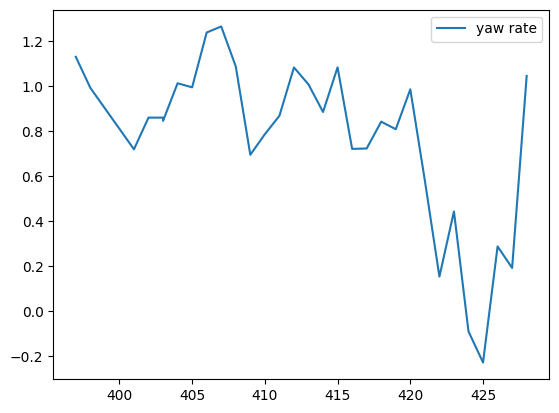

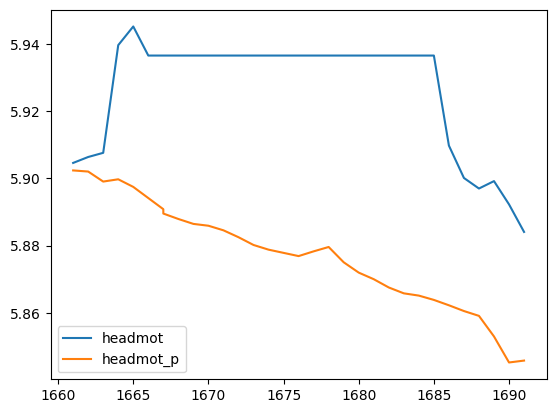

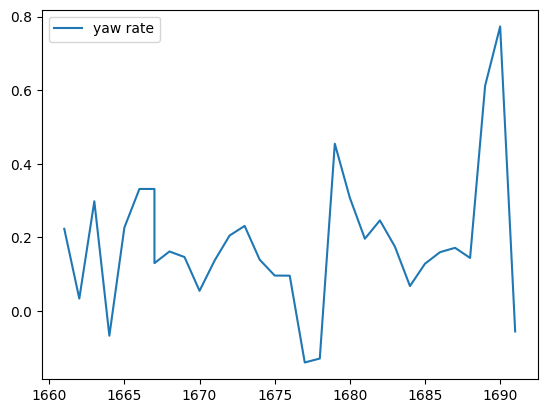

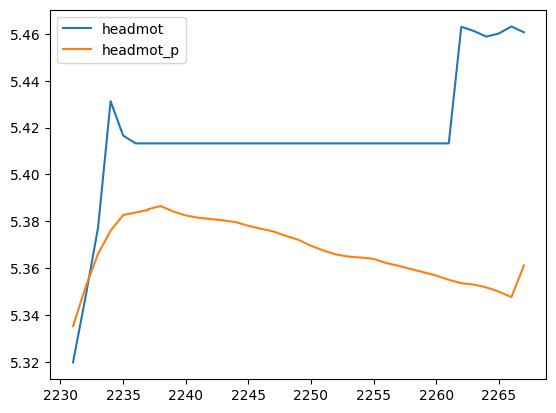

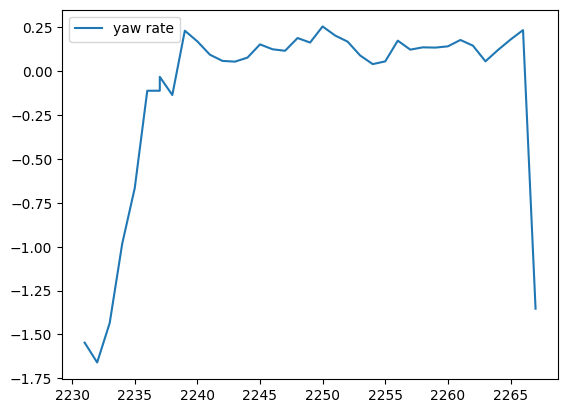

In [110]:
# Detection Code

# dataframe 주어졌을 때, numSV=0 구간에 대해, 터널 시작 및 끝 안전거리 기준으로 s와 e 찍기

def detection(data, s_dist=200, e_dist = 150, numSV_ths = 10):
    data_outage = data.loc[data["numSV"] == 0]
    
    def group_consecutive(data):
     return np.split(data, np.where(np.diff(data.index) != 1)[0] + 1)
 
    data_outage_split = group_consecutive(data_outage)
    
    def filter_outage_sections(data_outage_split, speed_col="Speed", threshold=0.7):
        """
        주어진 리스트에서 정지 인덱스가 전체의 70% 이상인 섹션을 제거.
        """
        filtered_sections = []
        for outage_section in data_outage_split:
            zero_vel_index = outage_section.loc[(outage_section[speed_col] < 1)].index
            if len(zero_vel_index) <= threshold * len(outage_section):
                filtered_sections.append(outage_section)
        return filtered_sections

    data_outage_split = filter_outage_sections(data_outage_split)
    # 여기에서 시작 끝 점 기준으로 특정 인덱스 범위만큼 더 간 값들까지 붙여서 반환
    
    for idx, outage_section in enumerate(data_outage_split):
        
        s_i, o_i = outage_section.index[0], outage_section.index[-1]
        print(s_i, o_i)
        
        p_si, p_oi = data.loc[s_i - 10], data.loc[o_i + 10]
        
        try:
            s_o = s_i - int(s_dist/p_si["Speed"])
        except Exception as e:
            print("zero speed, detect as default distance")
            s_o = s_i - 7
        
        try:
            o_o = o_i + int(e_dist/p_oi["Speed_175"])
        except Exception as e:
            print("zero speed, detect as default distance")
            o_o = o_i + 5
        
        not_sat_s = True
        while not_sat_s:
            if (data.loc[s_o]["numSV"] > numSV_ths) and (data.loc[o_o]["numSV"] > numSV_ths):
                not_sat_s = False
            else:
                if (data.loc[s_o]["numSV"] <= numSV_ths) :
                    s_o = s_o - 1
                if (data.loc[o_o]["numSV"] <= numSV_ths):
                    o_o = o_o + 1
        
        
        outage_section_fin = pd.concat([data.loc[s_o:s_i], outage_section, data.loc[o_i + 1: o_o + 1]], axis = 0)
        
        data_outage_split[idx] = outage_section_fin
    
    return data_outage_split


acc_file = pd.read_csv(fr"Y:\99_Code_Library\YJW\6.data\102.GPS_outage\175\20240909.csv")
result = detection(kk.loc[0:4200])

for result_df in  result: #[kk.loc[1300:1600], kk.loc[1700:1800]] +
    fig = px.scatter_mapbox(result_df, lat = f'lat', lon= f'lon', color= f"headMot", zoom=15, mapbox_style='open-street-map', color_continuous_scale='turbo').update_traces(marker={'size':5})
    fig.update_layout(
        width = 1200,
        height = 900,
        margin = dict(l=0, r=0, t=0, b=0),
    )
    fig.show()
    
    init_heading = result_df.iloc[0]["headMot"]
    
    
    # 아마 cali 제대로 안되어 있어서 z 가 거꾸로 뒤집혀 잇었던 듯
    # 그리고 scale도 안맞아서 특정 scale factor 80(?) 곱해야지 됨
    # anglerate Y 도 마찬가지로 다시 손봐야 할듯
    
    
    plt.plot(result_df["headMot"], label="headmot")
    plt.plot(-pd.Series(np.roll(result_df["AngleRateZ_cal"].rolling(1).mean(), -1), index = result_df.index).cumsum()/100 + init_heading, label="headmot_p")
    plt.legend()
    
    plt.show()
    plt.plot(pd.Series(np.roll(result_df["AngleRateZ_cal"].rolling(1).mean(), -1), index = result_df.index), label="yaw rate")
    plt.legend()
    plt.show()

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

array([-0.43711838,  0.1596843 , -0.18239946, -0.08618423,  0.2900625 ,
       -0.11474887, -0.11189911, -0.11189911, -0.25035379, -0.06329715,
       -0.25601874,  0.25488229, -0.10842067, -0.54701311, -0.1418261 ,
       -0.21866601, -0.15154239, -0.18661415, -0.04381598, -0.35679096,
       -0.30999274,  0.18552886, -0.24751548,  0.04457414, -0.04216554,
        0.28556463, -0.18466283, -0.55826903, -0.33590135,  0.13479082,
        0.19263687, -0.11836047, -0.27581937])

(2.29025037, 0.07728361)

(2.63917101, 0.00704443)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])

array([-0.27581937, -0.11836047,  0.19263687,  0.13479082, -0.33590135,
       -0.55826903, -0.18466283,  0.28556463, -0.04216554,  0.04457414,
       -0.24751548,  0.18552886, -0.30999274, -0.35679096, -0.04381598,
       -0.18661415, -0.15154239, -0.21866601, -0.1418261 , -0.54701311,
       -0.10842067,  0.25488229, -0.25601874, -0.06329715, -0.25035379,
       -0.11189911, -0.11189911, -0.11474887,  0.2900625 , -0.08618423,
       -0.18239946,  0.1596843 , -0.43711838])

Height diff as -9.413000000000011   estimated as -8.475310496273014
Speed diff as 0.5560000000000009   estimated as -0.8653565332816814
Heading diff as -0.34892063900510006   estimated as -0.32916303805912905
Slope diff as -0.07023917780310486   estimated as -0.022769529206720544
Radius diff as 907.0593028062679   estimated as 914.142190867708


(1.7258404e+09, 18., 262.555, 29.101, -0.43711838, 0.22762935, 9.8065721, -0.81402052, 0.3470516, 1.35942732, 5.78076366, 35.9650811, 127.6591713, -0.00704443, 0., 0.)

(1.72584043e+09, 17., 253.142, 29.657, -0.27581937, 0.22650106, 9.9808968, -1.16268093, 0.09736857, 0.50422794, 5.43184302, 35.9712075, 127.6525133, -0.07728361, 907.05930281, -0.34892064)

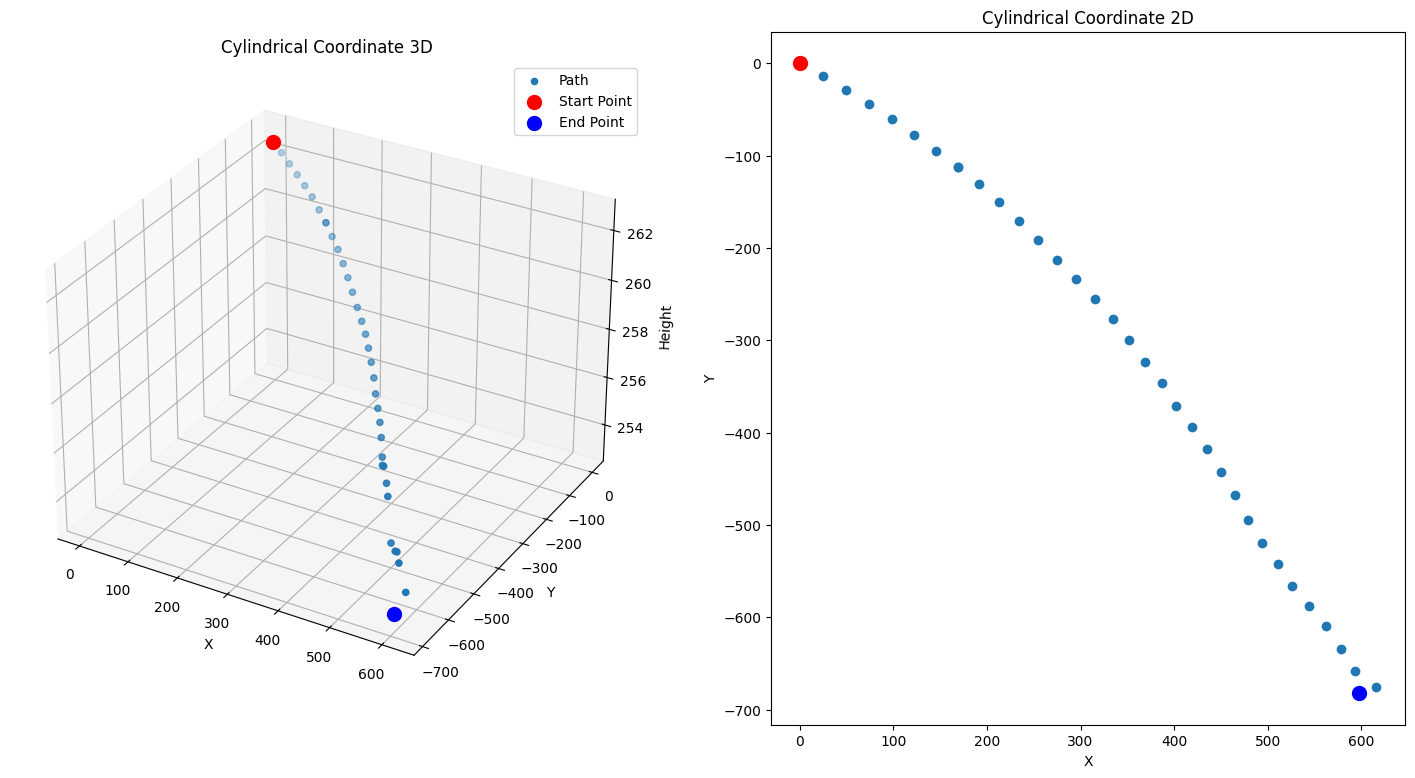

Height diff as 9.413000000000011   estimated as 49.891845939325364
Speed diff as -0.5560000000000009   estimated as -26.74853195975418
Heading diff as 0.34892063900510006   estimated as 0.32916303805912905
Slope diff as -0.07023917780310486   estimated as 0.022769529206720537
Radius diff as 907.0593028062679   estimated as 511.4274290624917


(1.72584043e+09, 17., 253.142, 29.657, -0.27581937, 0.22650106, 9.9808968, -1.16268093, 0.09736857, 0.50422794, 2.29025037, 35.9712075, 127.6525133, 0.07728361, 0., -0.)

(1.7258404e+09, 18., 262.555, 29.101, -0.43711838, 0.22762935, 9.8065721, -0.81402052, 0.3470516, 1.35942732, 2.63917101, 35.9650811, 127.6591713, 0.00704443, 907.05930281, 0.34892064)

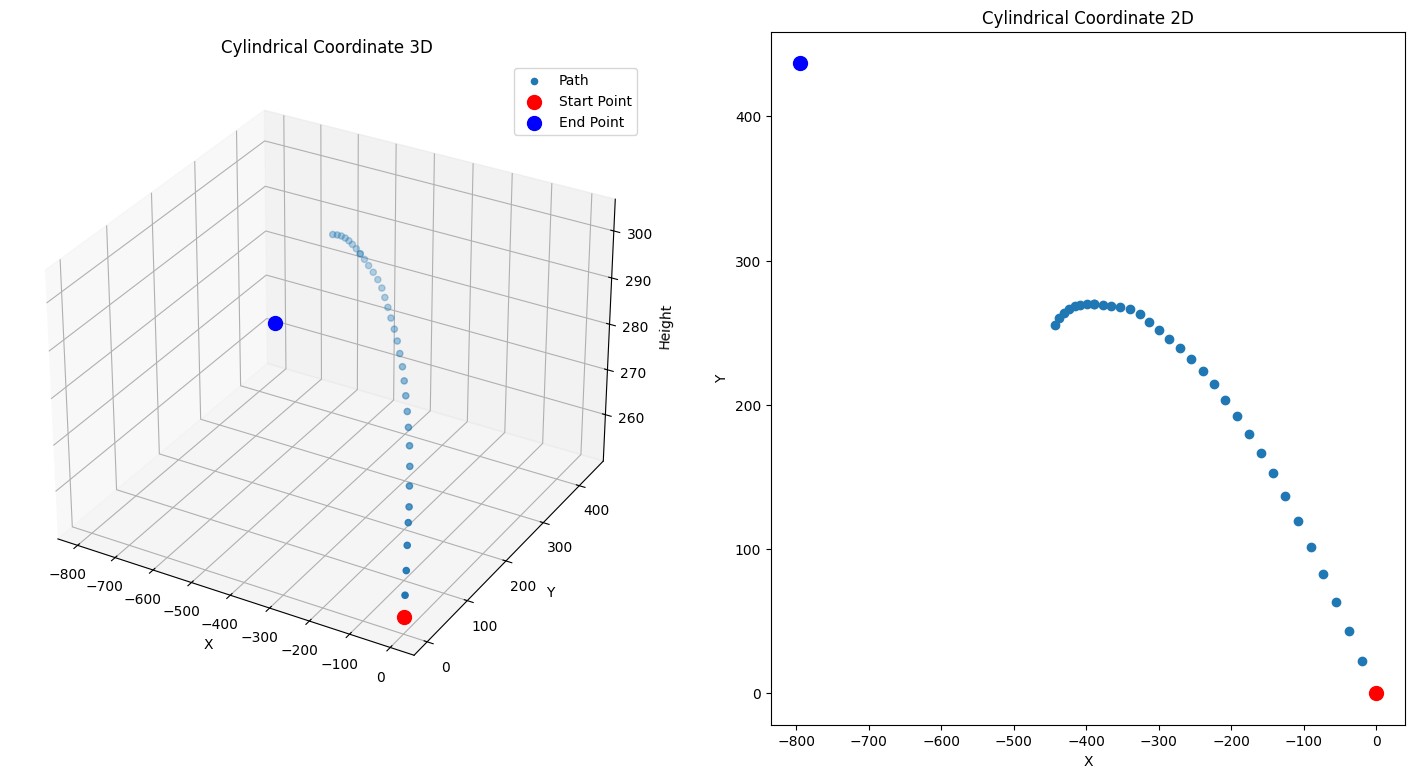

In [ ]:
from pyproj import Geod

# 이미 calibration 된 데이터에서 initailize한 한부분을 df로 받음
def initialize(df, linear_slope=False, reverse = False):
    
    df["TimeStamp"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df["UnixTime"] = df["TimeStamp"].apply(lambda x: x.timestamp())
    
    data = np.array([tuple(x) for x in np.vstack( \
                (df['UnixTime'], \
                    df['numSV'], \
                    df['height'], \
                    df['Speed'], \
                    df['AccelX'], \
                    df['AccelY'], \
                    df['AccelZ'], \
                    df['AngleRateX'], \
                    df['AngleRateY'], \
                    df['AngleRateZ'], \
                    df["headMot"], \
                    df["lat"], \
                    df["lon"], 
                    )).T], \

                dtype = [('TimeStamp', None), \
                        ('numSV', None), \
                        ('Height', None), \
                        ('Speed', None), \
                        ('AccelX', None), \
                        ('AccelY', None), \
                        ('AccelZ', None), \
                        ('AngleRateX', None), \
                        ('AngleRateY', None), \
                        ('AngleRateZ', None), \
                        ('Heading', None),  \
                        ('Lat', None), \
                        ('Lon', None), 
                        ])
    
    # 변화량은 소문자로 표기, 합친 값은 대문자로 표기기
    delta_p = {
        "heading": np.zeros(len(data)),
        "slope" :  np.zeros(len(data)),
        "speed" :  np.zeros(len(data)),
        "height" :  np.zeros(len(data)),
        "radius" :  np.zeros(len(data)),
    }
    
    # 원통형 좌표계로 start_point, end_point 변환
    
    geod = Geod(ellps="WGS84")
    
    time_delta = np.diff(data["TimeStamp"])
    time_delta = np.insert(time_delta, 0, time_delta[0])
    
    dt = data.dtype.descr.copy()
    dt.append(('Slope', '<f8'))
    dt.append(('Radius', '<f8'))
    dt.append(('Theta', '<f8'))

    start_point = data[0].copy()
    end_point = data[-1].copy()
    
    start_point = np.zeros(1, dtype=dt)[0]
    end_point = np.zeros(1, dtype=dt)[0]

    for name in data.dtype.names:
        start_point[name] = data[name][0]
        end_point[name] = data[name][-1]
    
    start_point["Slope"] = (data["Height"][1] - data["Height"][0])/(data["Speed"][0] * time_delta[0])
    end_point["Slope"] = (data["Height"][-1] - data["Height"][-2])/(data["Speed"][-1] * time_delta[-1])
    
            
    azimuth, _, distance = geod.inv(start_point["Lon"], start_point["Lat"], end_point["Lon"], end_point["Lat"])
    
    start_point["Radius"] = 0
    end_point["Radius"] = distance
    start_point["Theta"] = 0
    end_point["Theta"] =  end_point["Heading"] - start_point["Heading"]
    
    # initialize 하기 전에 각속도는 일단 MA 쳐야함. 마지막의 None 값은 data의 값 그대로 사용
    window_size_yaw = 1
    window_size_pitch = 10
    
    def ma_concat(data, ma, window_size):
        data_MA = np.full(len(data), np.nan)
        
        # 시작과 끝 부분 처리
        data_MA[-(window_size):] = data[-(window_size):] / window_size
        data_MA[:-(window_size)] = ma[:-(window_size)]
        
        return data_MA
    # Heading diff = - Yaw Rate, window 1로 그대로 사용
    Yaw_MA = -np.roll(df["AngleRateZ"].rolling(window_size_yaw).mean(), -window_size_yaw).copy()
    # Slope ~ Pitch Rate
    Pitch_MA = np.roll(df["AngleRateY"].rolling(window_size_pitch).mean(), -window_size_pitch).copy() / window_size_pitch
    
    Yaw_MA = ma_concat(data["AngleRateZ"], Yaw_MA, window_size_yaw)
    Pitch_MA = ma_concat(data["AngleRateY"], Pitch_MA, window_size_pitch)
    Accx_MA = data["AccelX"].copy()
    
    if reverse:
        start_point, end_point = end_point.copy(), start_point.copy()
        
        start_point["Radius"] = 0
        end_point["Radius"] = distance
        start_point["Theta"] = 0
        end_point["Theta"] =  - (end_point["Heading"] - start_point["Heading"])
        
        for point in [start_point, end_point]:
            point["Heading"] = point["Heading"] - np.pi
            point["Slope"] = - point["Slope"]
            point["Theta"] = - point["Theta"]
            display(point[["Heading", "Slope"]])
            
        Yaw_MA = np.flip(Yaw_MA)
        Pitch_MA = np.flip(Pitch_MA)
        Accx_MA = np.flip(Accx_MA)
        time_delta = np.flip(time_delta)
        
    # display("pitch", Pitch_MA)
    # display("yaw", Yaw_MA)
    display(time_delta)
    display(Accx_MA)
    
    def init_heading(heading_array, Yaw_MA, time_delta):
        heading_array[:] = Yaw_MA/100 * time_delta
        if reverse:
            heading_array[:] = - Yaw_MA/100 * time_delta
        return heading_array
    
    def init_slope(slope_array, Pitch_MA, time_delta):
        slope_array[:] = Pitch_MA * time_delta
        if reverse:
            slope_array[:] = - Pitch_MA * time_delta
        slope_array = np.diff(slope_array)
        slope_array = np.insert(slope_array, 0, 0)

        return slope_array
    
    def init_speed(start_point, speed_array, Accx_MA, slope_array, time_delta):
        Slope_array = start_point["Slope"] + np.cumsum(slope_array)
        speed_array[:] = (Accx_MA - 9.814 * np.sin(Slope_array)) * np.cos(Slope_array) * time_delta
        
        if reverse:
            Slope_array = start_point["Slope"] + np.cumsum(slope_array)
            speed_array[:] = - (Accx_MA - 9.814 * np.sin(-Slope_array)) * np.cos(-Slope_array) * time_delta
            
        return speed_array
    
    def init_height(start_point, height_array, speed_array, slope_array, time_delta):
        
        Slope_array = start_point["Slope"] + np.cumsum(slope_array)
        Speed_array = start_point["Speed"] + np.cumsum(speed_array)
        height_array[:] = Speed_array * np.tan(Slope_array) * np.abs(time_delta)
        
        if reverse:
            Slope_array = start_point["Slope"] + np.cumsum(slope_array)
            Speed_array = start_point["Speed"] + np.cumsum(speed_array)
            height_array[:] = Speed_array * np.tan(Slope_array) * time_delta
        
        
        return height_array
    
    def init_radius(start_point, radius_array, speed_array, heading_array, time_delta):
        if not reverse:
            Speed_array = start_point["Speed"] + np.cumsum(speed_array)
        else:
            Speed_array = start_point["Speed"] + np.cumsum(speed_array)
            
        radius_array[:] = Speed_array * np.cos(heading_array) * time_delta
        return radius_array
    
    def now_value(array, idx):
        sum_array = array.cumsum()
        return sum_array[idx]
    
    delta_p["heading"] = init_heading(delta_p["heading"], Yaw_MA, time_delta)
    
     # 단순 끝점 간 고도 차로 linear 하게 초기 slope 생성, delta slope는 전부 0으로 초기화. slope_s를 해당 slope 값으로 설정
    if linear_slope == True:
        delta_p["slope"] = np.linspace(start_point["Slope"], end_point["Slope"], len(data))
        if reverse:
            delta_p["slope"] = np.linspace(end_point["Slope"], start_point["Slope"], len(data))
    else:
        delta_p["slope"] = init_slope(delta_p["slope"], Pitch_MA, time_delta)
    delta_p["speed"] = init_speed(start_point, delta_p["speed"], Accx_MA, delta_p["slope"], time_delta)
    delta_p["height"] = init_height(start_point, delta_p["height"], delta_p["speed"], delta_p["slope"], time_delta)
    delta_p["radius"] = init_radius(start_point, delta_p["radius"], delta_p["speed"], delta_p["heading"], time_delta)
            
        
    return start_point, end_point, delta_p

def bi_direction(data):
    # 양방향으로 초기 값 생성하고, 내분해서 최종 초기화
    pass

s, e, delta_p = initialize(result[1])
ss, ee, delta_r = initialize(result[1], reverse=True)

%matplotlib inline
def visuallize(s, e, delta_p):

    for col, delta_col in zip(["Height", "Speed", "Heading", "Slope", "Radius"],
                ["height", "speed", "heading", "slope", "radius"]):
        print(col, "diff as", e[col] - s[col], " ", "estimated as", np.sum(delta_p[delta_col]))
        
    display(s)
    display(e)
    # display(delta_p)

    theta = np.cumsum(delta_p["heading"]) + s["Heading"]
    radius = np.cumsum(delta_p["radius"]) + s["Radius"]
    height = np.cumsum(delta_p["height"]) + s["Height"]

    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z = height

    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, label='Path')

    ax.scatter(s["Radius"] * np.cos(s["Heading"]), 
            s["Radius"] * np.sin(s["Heading"]), 
            s["Height"], 
            color='red', s=100, label='Start Point')
    ax.scatter(e["Radius"] * np.cos(e["Heading"]), 
            e["Radius"] * np.sin(e["Heading"]), 
            e["Height"], 
            color='blue', s=100, label='End Point')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height')
    ax.set_title('Cylindrical Coordinate 3D')
    ax.legend()

    az = fig.add_subplot(122)

    az.scatter(x, y, label='Path')
    az.scatter(s["Radius"] * np.cos(s["Heading"]), 
            s["Radius"] * np.sin(s["Heading"]), color='red', s=100, label='Start Point')
    az.scatter(e["Radius"] * np.cos(e["Heading"]), 
            e["Radius"] * np.sin(e["Heading"]), color='blue', s=100, label='End Point')
    az.set_title('Cylindrical Coordinate 2D')
    az.set_xlabel('X')
    az.set_ylabel('Y')
    plt.show()

visuallize(s, e, delta_p)
visuallize(ss, ee, delta_r)

In [203]:
np.sum((result[1]["AngleRateY"]/10).diff())
#ss["Slope"] + np.cumsum(delta_r["slope"])

-0.024968302304938753

In [194]:
display(delta_p)
display(delta_r)
result[0][::-1]

{'heading': array([-0.01443181, -0.01305448, -0.01215849, -0.01122966, -0.01035696,
        -0.01174126, -0.01174126, -0.        , -0.01326163, -0.01309521,
        -0.01550764, -0.01578579, -0.01401351, -0.01007507, -0.01100588,
        -0.01182394, -0.01396877, -0.01318683, -0.01200091, -0.01397073,
        -0.01034351, -0.01036006, -0.01155065, -0.01122864, -0.0130087 ,
        -0.00892646, -0.00467459, -0.0075191 , -0.00224379, -0.00087799,
        -0.00601976, -0.00504228,  0.00504228]),
 'slope': array([ 0.        , -0.00018768,  0.00055919, -0.0001987 ,  0.00024163,
        -0.00232524,  0.00022329, -0.03081889,  0.02971942,  0.00131507,
        -0.00140923,  0.00052003, -0.00062841, -0.00114618,  0.00205622,
         0.00139736, -0.00112873, -0.00027308, -0.00196104, -0.00048406,
         0.00206351,  0.00096494, -0.00151311, -0.00600676,  0.01633038,
         0.01037565, -0.02290999,  0.00533477, -0.04795846,  0.05533511,
         0.01105013, -0.01494155, -0.02636511]),
 'spee

{'heading': array([-0.00504228,  0.00504228,  0.00601976,  0.00087799,  0.00224379,
         0.0075191 ,  0.00467459,  0.00892646,  0.0130087 ,  0.01122864,
         0.01155065,  0.01036006,  0.01034351,  0.01397073,  0.01200091,
         0.01318683,  0.01396877,  0.01182394,  0.01100588,  0.01007507,
         0.01401351,  0.01578579,  0.01550764,  0.01309521,  0.01326163,
         0.        ,  0.01174126,  0.01174126,  0.01035696,  0.01122966,
         0.01215849,  0.01305448,  0.01443181]),
 'slope': array([ 0.        , -0.02636511, -0.01494155,  0.01105013,  0.05533511,
        -0.04795846,  0.00533477, -0.02290999,  0.01037565,  0.01633038,
        -0.00600676, -0.00151311,  0.00096494,  0.00206351, -0.00048406,
        -0.00196104, -0.00027308, -0.00112873,  0.00139736,  0.00205622,
        -0.00114618, -0.00062841,  0.00052003, -0.00140923,  0.00131507,
         0.02971942, -0.03081889,  0.00022329, -0.00232524,  0.00024163,
        -0.0001987 ,  0.00055919, -0.00018768]),
 'spee

,datetime,hAcc,headMot,height,lat,lon,numSV,Speed,AccelX,AccelY,AccelZ,AngleRateX,AngleRateY,AngleRateZ,AngleRateX_cal,AngleRateY_cal,AngleRateZ_cal,TimeStamp,UnixTime
235,2024-09-09 00:03:55,20.2,5.896573,316.005,35.923634,127.661461,11.0,29.573,-0.539588,-0.112631,9.826151,-0.384567,0.288753,0.941854,0.212922,0.069462,0.628296,2024-09-09 00:03:55,1.725840e+09
234,2024-09-09 00:03:54,23.1,5.902597,313.831,35.923415,127.661583,12.0,29.885,-0.493909,-0.126237,9.955813,-0.752036,0.263848,0.857418,-0.153888,0.036401,0.543792,2024-09-09 00:03:54,1.725840e+09
233,2024-09-09 00:03:53,28.1,5.908193,306.731,35.923190,127.661674,11.0,30.031,-0.002579,-0.134535,9.686261,-1.009884,0.501940,0.744667,-0.416361,0.268220,0.428668,2024-09-09 00:03:53,1.725840e+09
232,2024-09-09 00:03:52,38.6,5.910736,308.881,35.923021,127.661731,10.0,29.822,0.010329,-0.259745,9.956230,-1.012910,0.171153,0.548291,-0.412538,-0.064333,0.235311,2024-09-09 00:03:52,1.725840e+09
231,2024-09-09 00:03:51,55.6,5.918368,303.411,35.923214,127.661621,10.0,30.039,-0.121190,-0.259545,9.784966,-1.074901,0.417944,0.770446,-0.479701,0.183170,0.455159,2024-09-09 00:03:51,1.725840e+09
230,2024-09-09 00:03:50,284.6,5.922571,235.515,35.921719,127.661859,5.0,28.611,-0.205391,-0.030796,9.799520,-2.450429,0.469260,0.764488,-1.855976,0.206737,0.447618,2024-09-09 00:03:50,1.725840e+09
229,2024-09-09 00:03:49,157.2,5.929105,349.771,35.920555,127.662752,0.0,0.000,-0.412041,0.201218,9.973603,-1.859777,0.314363,0.483878,-1.262050,0.061213,0.168910,2024-09-09 00:03:49,1.725840e+09
228,2024-09-09 00:03:48,143.6,5.929105,349.771,35.920555,127.662752,0.0,0.000,-0.224084,0.230975,9.887621,-0.910456,0.190846,0.636030,-0.310588,-0.041784,0.322950,2024-09-09 00:03:48,1.725840e+09
227,2024-09-09 00:03:47,130.5,5.929105,349.771,35.920555,127.662752,0.0,0.000,-0.139674,0.201873,9.818800,-0.906670,0.354394,0.506167,-0.309963,0.120619,0.191606,2024-09-09 00:03:47,1.725840e+09
226,2024-09-09 00:03:46,117.7,5.929105,349.771,35.920555,127.662752,0.0,0.000,-0.056307,0.269827,9.891190,-0.578877,0.433566,0.722110,0.015955,0.208332,0.407085,2024-09-09 00:03:46,1.725840e+09
